In [1]:
import sys
import numpy as np
import spectral as sp
import scipy
import matplotlib as mpl
import matplotlib.pyplot as plt
from tqdm import tqdm

sys.path.append('../')
from preprocessing import *
from unmixing_algorithms import *
from extinctions import *
from plotting_parameters import *
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable

### Load endmember spectra

In [2]:
bands_range = [520,900]
band_centers = np.arange(bands_range[0], bands_range[1]+1)

extinction_dict = get_extinctions(bands_range)
cyt_c_ox = extinction_dict["cyt_c_ox"]
cyt_c_red = extinction_dict["cyt_c_red"]
cyt_b_ox = extinction_dict["cyt_b_ox"]
cyt_b_red = extinction_dict["cyt_b_red"]
cyt_oxi_ox = extinction_dict["cyt_oxi_ox"]
cyt_oxi_red = extinction_dict["cyt_oxi_red"]
hb = extinction_dict["hb"]
hbo2 = extinction_dict["hbo2"]
water = extinction_dict["water"]
fat = extinction_dict["fat"]
ones = np.ones_like(water)
scatter_ray = (band_centers/500)**(-4)

# remove cytochrome difference spectra as they are not needed for helicoid
_ = extinction_dict.pop("cyt_c_diff")
_ = extinction_dict.pop("cyt_b_diff")
_ = extinction_dict.pop("cyt_oxi_diff")


extinction_array = np.vstack([extinction_dict[key] for key in extinction_dict.keys()])

M = np.vstack((cyt_c_ox, cyt_c_red, cyt_b_ox, cyt_b_red, cyt_oxi_ox, cyt_oxi_red, hb, hbo2, water, fat)).T
endmember_labels = ["Cyt c ox", "Cyt c red", "Cyt b ox", "Cyt b red", "Cyt oxi ox", "Cyt oxi red", "Hb", "HbO2", "Water", "Fat"]

M_ones = np.vstack((cyt_c_ox, cyt_c_red, cyt_b_ox, cyt_b_red, cyt_oxi_ox, cyt_oxi_red, hb, hbo2, water, fat, ones)).T
endmember_labels_ones = ["Cyt c ox", "Cyt c red", "Cyt b ox", "Cyt b red", "Cyt oxi ox", "Cyt oxi red", "Hb", "HbO2", "Water", "Fat", "ones"]

M_ones_scatter = np.vstack((cyt_c_ox, cyt_c_red, cyt_b_ox, cyt_b_red, cyt_oxi_ox, cyt_oxi_red, hb, hbo2, water, fat, ones, scatter_ray)).T
endmember_labels_ones_scatter = ["Cyt c ox", "Cyt c red", "Cyt b ox", "Cyt b red", "Cyt oxi ox", "Cyt oxi red", "Hb", "HbO2", "Water", "Fat", "ones", "scatter"]

M_scatter = np.vstack((cyt_c_ox, cyt_c_red, cyt_b_ox, cyt_b_red, cyt_oxi_ox, cyt_oxi_red, hb, hbo2, water, fat, scatter_ray)).T
endmember_labels_scatter = ["Cyt c ox", "Cyt c red", "Cyt b ox", "Cyt b red", "Cyt oxi ox", "Cyt oxi red", "Hb", "HbO2", "Water", "Fat", "ones"]

### Load Hyperspectral image

/home/martin_ivan/anaconda3/envs/thesis/lib/python3.10/site-packages/spectral/io/envi.py:175: UserWarning: Parameters with non-lowercase names encountered and converted to lowercase. To retain source file parameter name capitalization, set spectral.settings.envi_support_nonlowercase_params to True.
  warnings.warn(msg)


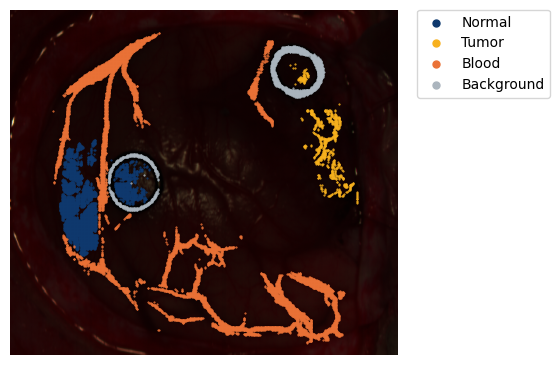

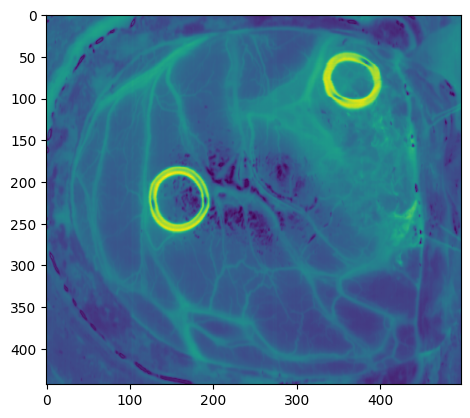

In [31]:
data_folder = "../../datasets/helicoid/012-01"
class_labels = ["Not labled", "Normal", "Tumor", "Blood", "Background"]
class_colors = ["white", tum_blue_dark_2, tum_orange, tum_red, tum_grey_5]

# Load the sp data
img = sp.open_image(data_folder + "/raw.hdr")
white_ref = sp.open_image(data_folder + "/whiteReference.hdr")
dark_ref = sp.open_image(data_folder + "/darkReference.hdr")
gt_map = sp.open_image(data_folder + "/gtMap.hdr")

plot_img(img, gt_map, class_labels, class_colors, figsize=(5,5), legend=True)


img_interp, band_centers = bands_lin_interpolation(img, img.bands.centers, bands_range)
white_ref_interp, _ = bands_lin_interpolation(white_ref, img.bands.centers, bands_range)
dark_ref_interp, _ = bands_lin_interpolation(dark_ref, img.bands.centers, bands_range)
img_calib = calibrate_img(img_interp, white_ref_interp, dark_ref_interp)
img_smooth = smooth_spectral(img_calib, 5)
# img_calib_norm = img_calib / np.linalg.norm(img_calib, axis=(0,1), keepdims=True)
absorbance = -np.log(img_smooth - np.min(img_smooth.flatten()) + 1e-8)

plt.figure()
img_sum = np.linalg.norm(absorbance, axis=-1, ord=1)
plt.imshow(img_sum)

### Plotting functions

In [10]:
def check_fit_mie(b_mie_img, P, abs):
    np.random.seed(42)
    # plot 40 random pixel spectra as well as the fit
    m, l, k = abs.shape
    n = M.shape[1]
    fig, axs = plt.subplots(8, 5, figsize=(15,20))
    for i in range(40):
        idx_1 = np.random.randint(0, m)
        idx_2 = np.random.randint(0, l)
        axs[i//5,i%5].plot(band_centers, abs[idx_1,idx_2,:], label="abs", color="r", linewidth=2)

        scatter_mie = (band_centers/500)**(-b_mie_img[idx_1,idx_2])
        scatter_mie_proj = P @ scatter_mie
        lam = np.dot(scatter_mie_proj, abs[idx_1,idx_2,:]) / np.linalg.norm(scatter_mie_proj)**2

        axs[i//5,i%5].plot(band_centers, lam * scatter_mie_proj, label="fit", color="k", linewidth=2)

    # place legend centered below the subplots
    axs[7,2].legend(loc="upper center", bbox_to_anchor=(0.5, -0.2), ncol=5)
    return fig, axs

from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable

def plot_concentrations(c, endmember_labels=None, figsize=(15,5)):
    N = c.shape[2]
    if N < 5:
        fig, axs = plt.subplots(1, N, figsize=figsize)
        for i in range(N):
            axs[i].imshow(c[:,:,i])
            axs[i].set_title(endmember_labels[i])
            axs[i].axis("off")
            # add colorbar
            divider = make_axes_locatable(axs[i])
            cax = divider.append_axes("right", size="5%", pad=0.05)
            plt.colorbar(axs[i].images[0], cax=cax)
    else:
        fig, axs = plt.subplots(int(np.ceil(N/5)), 5, figsize=figsize)
        for i in range(N):
            axs[i//5,i%5].imshow(c[:,:,i])
            axs[i//5,i%5].set_title(endmember_labels[i])
            axs[i//5,i%5].axis("off")
            # add colorbar
            divider = make_axes_locatable(axs[i//5,i%5])
            cax = divider.append_axes("right", size="5%", pad=0.05)
            plt.colorbar(axs[i//5,i%5].images[0], cax=cax)
    _ = plt.tight_layout()
    return fig, axs

def plot_error_img(err):
    fig, ax = plt.subplots(1,1, figsize=(3,3))
    err_img = plt.imshow(np.linalg.norm(err, axis=2))
    print(np.linalg.norm(err.flatten()))
    fig.colorbar(err_img, ax=ax)
    return fig, ax

### Scattering power optimization functions

scipy LS

In [5]:
def f(b_mie, *args):
    P, abs_proj = args
    scatter_mie = (band_centers/500)**(-b_mie)
    scatter_mie_proj = P @ scatter_mie
    abs_proj = abs_proj / np.linalg.norm(abs_proj) + 1e-8
    similarity = np.dot(scatter_mie_proj, abs_proj) / (np.linalg.norm(scatter_mie_proj) + 1e-8)
    # |a-b|^2 = a^Ta + b^Tb - 2a^Tb = 2 - 2a^Tb = 2 - 2*similarity for normalized vectors a and b
    d = 2 - 2*similarity
    return d

def d_f(b_mie, *args):
    P, abs_proj = args
    scatter_mie = (band_centers/500)**(-b_mie)
    scatter_mie_norm = np.linalg.norm(scatter_mie)
    abs_proj = abs_proj / np.linalg.norm(abs_proj) + 1e-8

    d_d = -2
    d_similarity = abs_proj/scatter_mie_norm - scatter_mie * np.dot(abs_proj, scatter_mie) / (scatter_mie_norm**3)
    d_scatter_mie_proj = P
    d_scatter_mie = - np.log(band_centers/500) * scatter_mie

    return d_d * d_similarity.T @ d_scatter_mie_proj @ d_scatter_mie

def optimize_scatter_ls(P, abs_proj):
    result = np.zeros_like(abs_proj[:,:,0])
    for i in tqdm(range(abs_proj.shape[0])):
        for j in range(abs_proj.shape[1]):
            x0 = 1.3
            bounds = (0, 10)
            args = (P, abs_proj[i, j, :])
            result[i,j] = scipy.optimize.least_squares(f, x0=x0, args=args, bounds=bounds, jac=d_f).x
    return result       

gradient descent

100%|██████████| 200/200 [09:09<00:00,  2.75s/it]


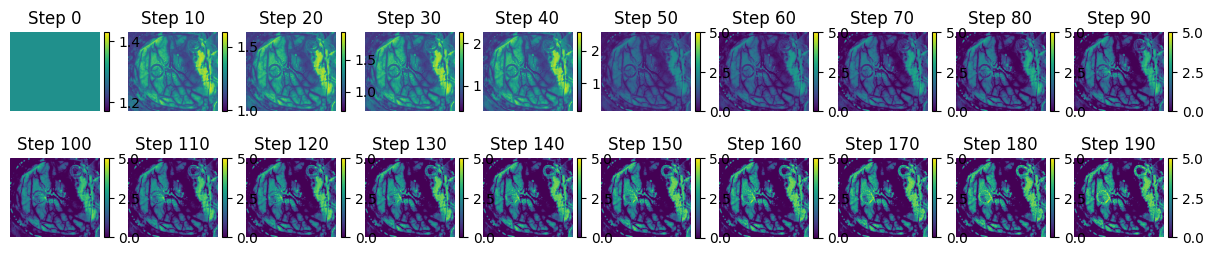

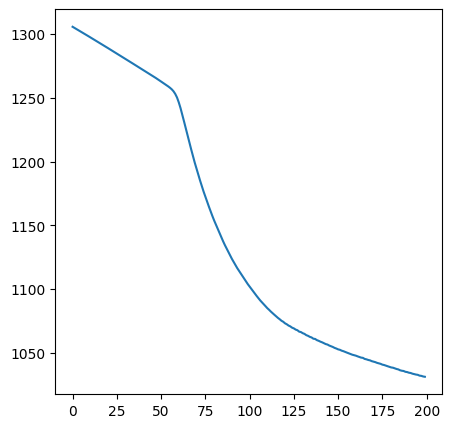

In [31]:
abs_proj, _ = project_absorbance(absorbance, M_ones_scatter.T, M_ones_scatter.T)
P = np.eye(M_ones_scatter.shape[0]) - M_ones_scatter @ np.linalg.pinv(M_ones_scatter)

def f(b_mie, *args):
    P, abs_proj, band_centers = args

    n = b_mie.shape[0]
    k = band_centers.shape[0]
    band_centers = band_centers.repeat(n, 1)
    b_mie = b_mie.repeat(k, 1).T
    
    scatter_mie = torch.pow(band_centers/500, -b_mie)
    scatter_mie_proj = torch.einsum("ij,...j->...i", P.double(), scatter_mie.double())
    abs_proj = abs_proj / (torch.norm(abs_proj, dim=1, keepdim=True) + 1e-12)
    scatter_mie_proj = scatter_mie_proj / (torch.norm(scatter_mie_proj, dim=1, keepdim=True) + 1e-12)
    similarity = torch.einsum("...i,...i->...", scatter_mie_proj.double(), abs_proj.double())
    d = 2 - 2*similarity
    return d

def d_f(b_mie, *args):
    eps = 1e-8
    d1 = f(b_mie + eps, *args)
    d2 = f(b_mie - eps, *args)
    return (d1 - d2) / (2*eps)

def gradient_descent(b_mie, *args, steps=200):
    fig, axs = plt.subplots(steps//100,10,figsize=(15,3))
    error = np.zeros(steps)

    for i in tqdm(range(steps)):
        grad = d_f(b_mie, *args)
        b_mie = b_mie - 0.1 * grad
        b_mie[b_mie < 0] = 0
        b_mie[b_mie > 5] = 5

        error[i] = torch.norm(f(b_mie, *args)).item()

        if i%10 == 0:
            ax = axs[i//100, (i%100)//10]
            ax.imshow(b_mie.reshape(abs_proj[:,:,0].shape))
            ax.set_title(f"Step {i}")
            ax.axis("off")
            # add colorbar
            divider = make_axes_locatable(ax)
            cax = divider.append_axes("right", size="5%", pad=0.05)
            plt.colorbar(ax.images[0], cax=cax)

    plt.figure(figsize=(5,5))
    plt.plot(error)

    return b_mie

x0 = 1.3 * torch.from_numpy(np.ones_like(abs_proj[:,:,0]).flatten())
bounds = (torch.zeros_like(x0), 10*torch.ones_like(x0))
abs_flat = abs_proj.reshape(-1,abs_proj.shape[-1])
args = (torch.from_numpy(P), torch.from_numpy(abs_flat), torch.from_numpy(band_centers))

b_mie_img = gradient_descent(x0, *args, steps=200).reshape(abs_proj[:,:,0].shape).numpy()

Mie scattering

  0%|          | 0/443 [00:00<?, ?it/s]/tmp/ipykernel_2078413/3489056861.py:31: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  result[i,j] = scipy.optimize.least_squares(f, x0=x0, args=args, bounds=bounds, jac=d_f).x
100%|██████████| 443/443 [08:25<00:00,  1.14s/it]


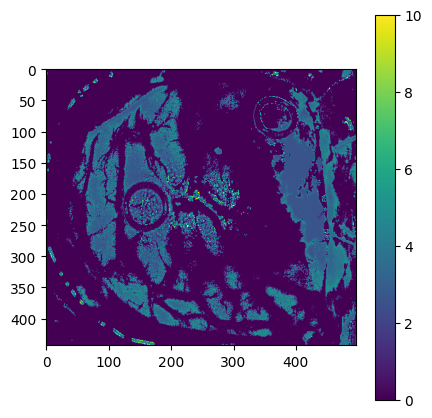

In [6]:
abs_proj_ones_scatter, _ = project_absorbance(absorbance, M_ones_scatter.T, M_ones_scatter.T)
P_ones_scatter = np.eye(M_ones_scatter.shape[0]) - M_ones_scatter @ np.linalg.pinv(M_ones_scatter)

b_mie_img = optimize_scatter_ls(P_ones_scatter, abs_proj_ones_scatter)

plt.figure(figsize=(5,5))
plt.imshow(b_mie_img)
plt.colorbar()

Simple Scattering

  0%|          | 0/443 [00:00<?, ?it/s]/tmp/ipykernel_2078413/3489056861.py:31: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  result[i,j] = scipy.optimize.least_squares(f, x0=x0, args=args, bounds=bounds, jac=d_f).x
100%|██████████| 443/443 [14:04<00:00,  1.91s/it]


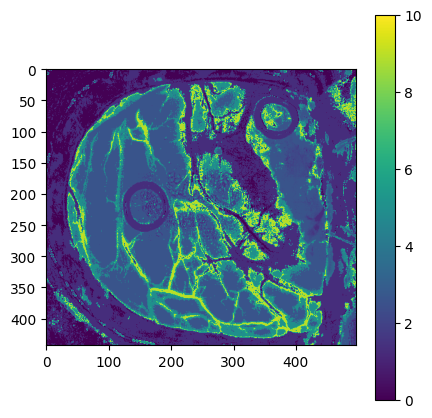

In [7]:
abs_proj_ones, _ = project_absorbance(absorbance, M_ones.T, M_ones.T)
P_ones = np.eye(M_ones.shape[0]) - M_ones @ np.linalg.pinv(M_ones)

b_simple_img = optimize_scatter_ls(P_ones, abs_proj_ones)

plt.figure(figsize=(5,5))
plt.imshow(b_simple_img)
plt.colorbar()

In [9]:
# save b_mie_img and b_simple_img as txt files
np.savetxt("b_mie_img.txt", b_mie_img)
np.savetxt("b_simple_img.txt", b_simple_img)

# load b_mie_img and b_simple_img from txt files
b_mie_img = np.loadtxt("b_mie_img.txt")
b_simple_img = np.loadtxt("b_simple_img.txt")

### Spectral unmixing

##### Cytochrome c oxibase

Removing Rayleigh scattering

100%|██████████| 443/443 [00:03<00:00, 116.11it/s]


466.59967453177416


(<Figure size 300x300 with 2 Axes>, <Axes: >)

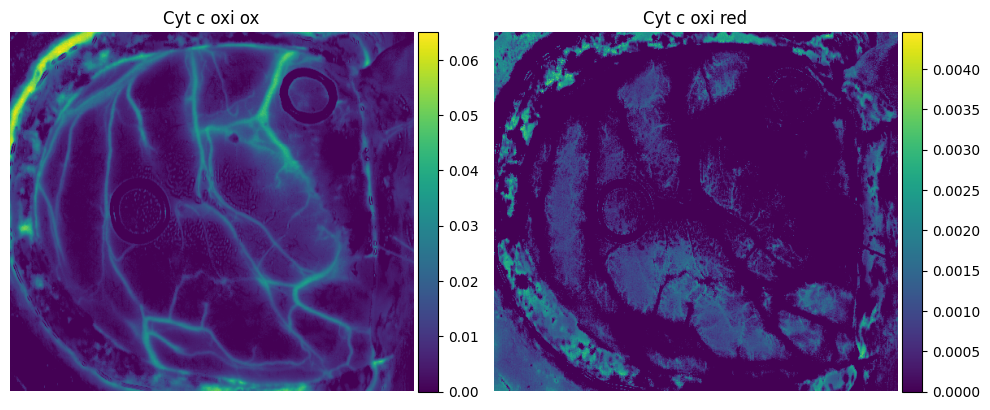

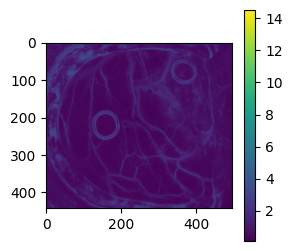

In [25]:
endmembers_proj_cyt_oxi = np.vstack((cyt_b_ox, cyt_b_red, cyt_c_ox, cyt_c_red, hb, hbo2, water, fat, ones, scatter_ray))
endmembers_unmix_cyt_oxi = np.vstack((cyt_oxi_ox, cyt_oxi_red))
absorbance_cyt_oxi_proj, endmembers_unmix_cyt_oxi_proj = project_absorbance(absorbance, endmembers_proj_cyt_oxi, endmembers_unmix_cyt_oxi, device="cuda")

M = endmembers_unmix_cyt_oxi_proj.T
c_cyt_oxi, err_cyt_oxi = unmix_LS_nonnegative(M, absorbance_cyt_oxi_proj)

endmember_labels=["Cyt c oxi ox", "Cyt c oxi red"]
plot_concentrations(c_cyt_oxi, endmember_labels, figsize=(10,5))

plot_error_img(err_cyt_oxi)

Removing Rayleigh and Mie scattering

  2%|▏         | 8/443 [00:03<03:10,  2.29it/s]

100%|██████████| 443/443 [03:16<00:00,  2.25it/s]


423.0489


(<Figure size 300x300 with 2 Axes>, <Axes: >)

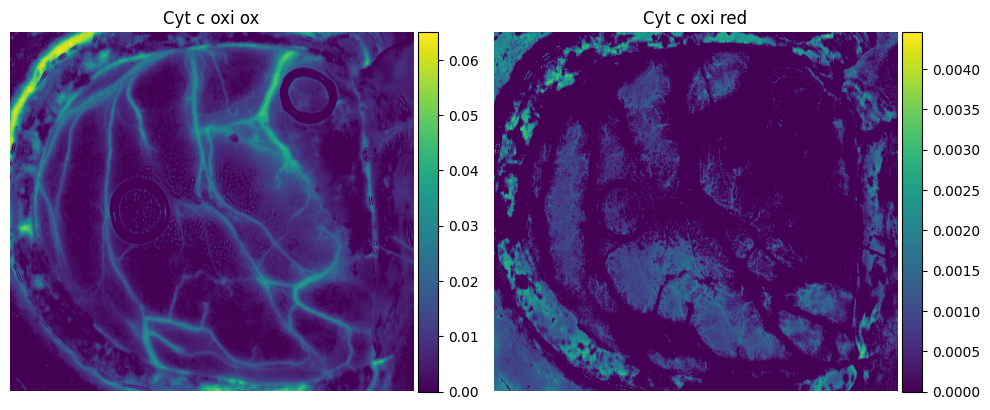

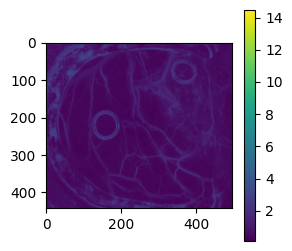

In [24]:
endmembers_proj = np.vstack((cyt_b_ox, cyt_b_red, cyt_c_ox, cyt_c_red, hb, hbo2, water, fat, ones, scatter_ray))

endmembers_unmix = np.vstack((cyt_oxi_ox, cyt_oxi_red))
absorbance_proj, endmembers_unmix_proj = project_absorbance(absorbance, endmembers_proj, endmembers_unmix, device="cuda")

c = np.zeros_like(absorbance_proj[:,:,0:2])
sim = np.zeros_like(absorbance_proj[:,:,0])
err = np.zeros_like(absorbance_proj)
P = np.eye(M_ones_scatter.shape[0]) - M_ones_scatter @ np.linalg.pinv(M_ones_scatter)
for i in tqdm(range(b_mie_img.shape[0])):
    for j in range(b_mie_img.shape[1]):
        scatter_mie = (band_centers/500)**(-b_mie_img[i,j])
        scatter_mie_proj = P @ scatter_mie
        P_mie = np.eye(M_ones_scatter.shape[0]) - np.outer(scatter_mie_proj, scatter_mie_proj) / np.linalg.norm(scatter_mie_proj)**2
        absorbance_proj[i,j,:] = P_mie @ absorbance_proj[i,j,:]
        M_pixel = P_mie @ endmembers_unmix_proj.T
        c_pixel, err_pixel = unmix_LS_nonnegative(M_pixel, absorbance_proj[i,j,:])
        c[i,j,:] = c_pixel
        err[i,j,:] = err_pixel
        

endmember_labels=["Cyt c oxi ox", "Cyt c oxi red"]
plot_concentrations(c, endmember_labels, figsize=(10,5))

plot_error_img(err)

# check_fit(c, M, absorbance_proj, endmember_labels)

Removing simplified scattering

100%|██████████| 443/443 [03:23<00:00,  2.17it/s]


448.82568


(<Figure size 300x300 with 2 Axes>, <Axes: >)

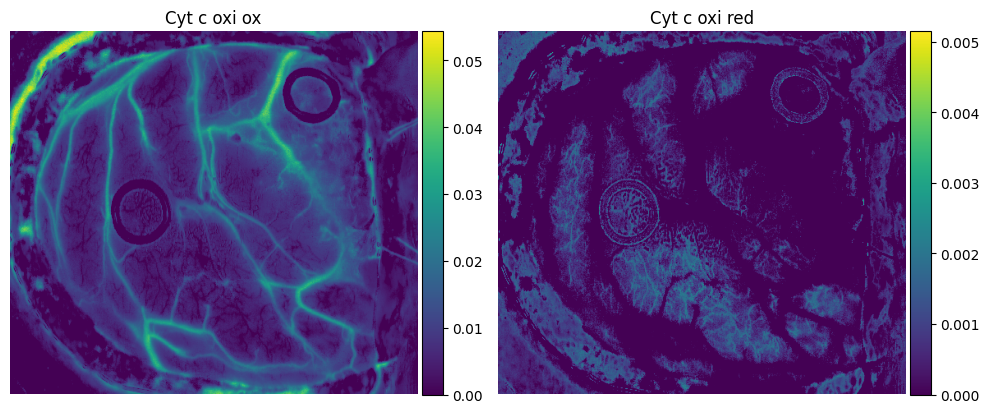

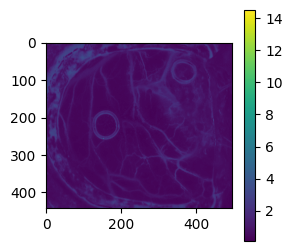

In [26]:
endmembers_proj = np.vstack((cyt_b_ox, cyt_b_red, cyt_c_ox, cyt_c_red, hb, hbo2, water, fat, ones))

endmembers_unmix = np.vstack((cyt_oxi_ox, cyt_oxi_red))
absorbance_proj, endmembers_unmix_proj = project_absorbance(absorbance, endmembers_proj, endmembers_unmix, device="cuda")

c = np.zeros_like(absorbance_proj[:,:,0:2])
sim = np.zeros_like(absorbance_proj[:,:,0])
err = np.zeros_like(absorbance_proj)
P = np.eye(M_ones.shape[0]) - M_ones @ np.linalg.pinv(M_ones)
for i in tqdm(range(b_simple_img.shape[0])):
    for j in range(b_simple_img.shape[1]):
        scatter_simple = (band_centers/500)**(-b_simple_img[i,j])
        scatter_simple_proj = P @ scatter_simple
        P_scatter = np.eye(M_ones.shape[0]) - np.outer(scatter_simple_proj, scatter_simple_proj) / np.linalg.norm(scatter_simple_proj)**2
        absorbance_proj[i,j,:] = P_scatter @ absorbance_proj[i,j,:]
        M_pixel = P_scatter @ endmembers_unmix_proj.T
        c_pixel, err_pixel = unmix_LS_nonnegative(M_pixel, absorbance_proj[i,j,:])
        c[i,j,:] = c_pixel
        err[i,j,:] = err_pixel
        

endmember_labels=["Cyt c oxi ox", "Cyt c oxi red"]
plot_concentrations(c, endmember_labels, figsize=(10,5))

plot_error_img(err)

##### Cytochrome c

Removing Rayleigh scattering

100%|██████████| 443/443 [00:03<00:00, 144.09it/s]


574.484499168838


(<Figure size 300x300 with 2 Axes>, <Axes: >)

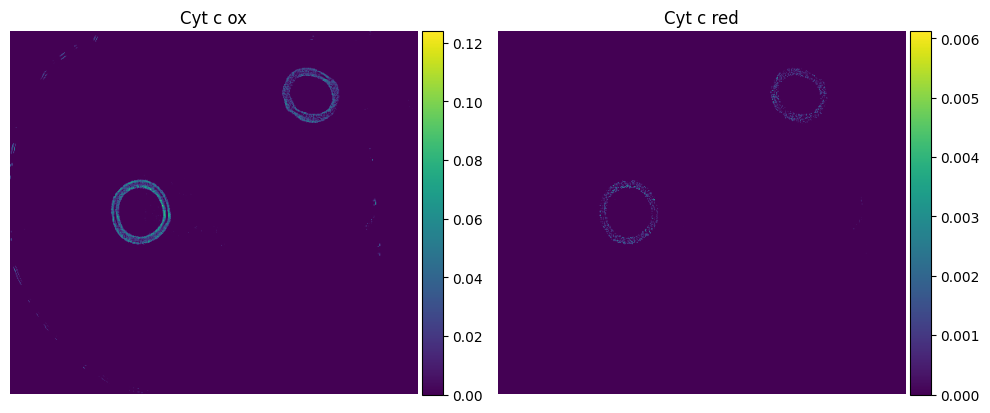

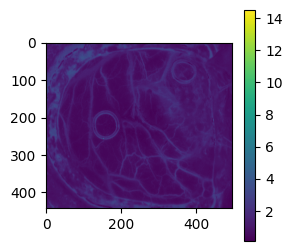

In [27]:
endmembers_proj_cyt_c = np.vstack((cyt_b_ox, cyt_b_red, cyt_oxi_ox, cyt_oxi_red, hb, hbo2, water, fat, ones, scatter_ray))
endmembers_unmix_cyt_c = np.vstack((cyt_c_ox, cyt_c_red))
absorbance_cyt_c_proj, endmembers_unmix_cyt_c_proj = project_absorbance(absorbance, endmembers_proj_cyt_c, endmembers_unmix_cyt_c, device="cuda")

M = endmembers_unmix_cyt_c_proj.T
c_cyt_c, err_cyt_c = unmix_LS_nonnegative(M, absorbance_cyt_c_proj)

endmember_labels=["Cyt c ox", "Cyt c red"]
plot_concentrations(c_cyt_c, endmember_labels, figsize=(10,5))

plot_error_img(err_cyt_c)

Removing Rayleigh and Mie scattering

100%|██████████| 443/443 [03:20<00:00,  2.21it/s]


539.47437


(<Figure size 300x300 with 2 Axes>, <Axes: >)

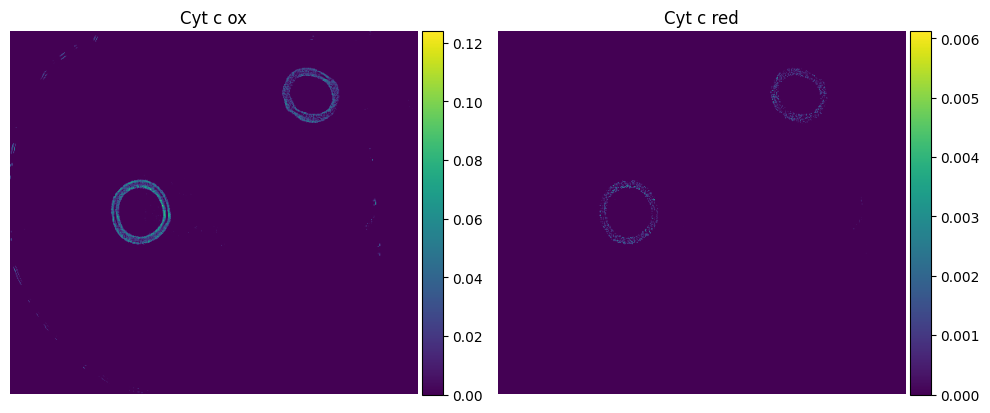

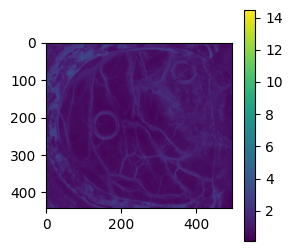

In [28]:
endmembers_proj = np.vstack((cyt_b_ox, cyt_b_red, cyt_oxi_ox, cyt_oxi_red, hb, hbo2, water, fat, ones, scatter_ray))

endmembers_unmix = np.vstack((cyt_c_ox, cyt_c_red))
absorbance_proj, endmembers_unmix_proj = project_absorbance(absorbance, endmembers_proj, endmembers_unmix, device="cuda")

c = np.zeros_like(absorbance_proj[:,:,0:2])
sim = np.zeros_like(absorbance_proj[:,:,0])
err = np.zeros_like(absorbance_proj)
P = np.eye(M_ones_scatter.shape[0]) - M_ones_scatter @ np.linalg.pinv(M_ones_scatter)
for i in tqdm(range(b_mie_img.shape[0])):
    for j in range(b_mie_img.shape[1]):
        scatter_mie = (band_centers/500)**(-b_mie_img[i,j])
        scatter_mie_proj = P @ scatter_mie
        P_mie = np.eye(M_ones_scatter.shape[0]) - np.outer(scatter_mie_proj, scatter_mie_proj) / np.linalg.norm(scatter_mie_proj)**2
        absorbance_proj[i,j,:] = P_mie @ absorbance_proj[i,j,:]
        M_pixel = P_mie @ endmembers_unmix_proj.T
        c_pixel, err_pixel = unmix_LS_nonnegative(M_pixel, absorbance_proj[i,j,:])
        c[i,j,:] = c_pixel
        err[i,j,:] = err_pixel
        

endmember_labels=["Cyt c ox", "Cyt c red"]
plot_concentrations(c, endmember_labels, figsize=(10,5))

plot_error_img(err)

Removing simplified scattering

100%|██████████| 443/443 [03:28<00:00,  2.13it/s]


585.665


(<Figure size 300x300 with 2 Axes>, <Axes: >)

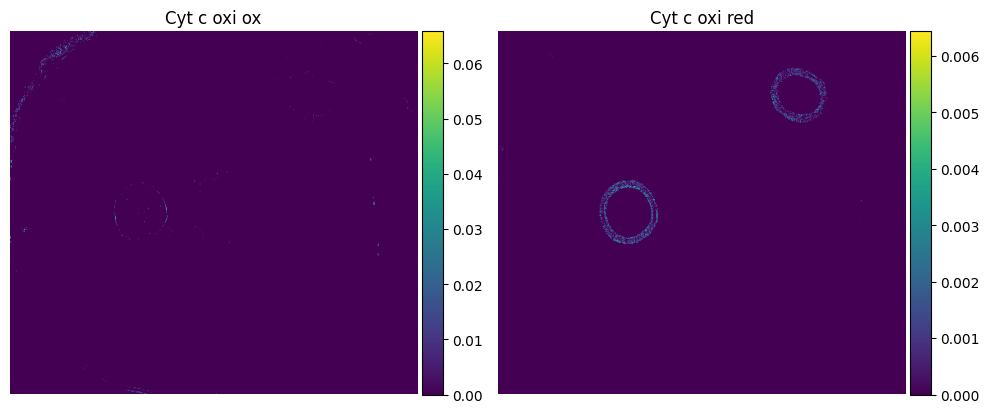

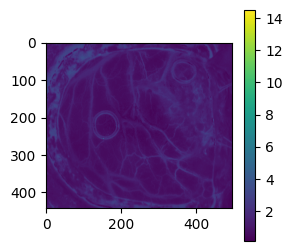

In [29]:
endmembers_proj = np.vstack((cyt_b_ox, cyt_b_red, cyt_oxi_ox, cyt_oxi_red, hb, hbo2, water, fat, ones))

endmembers_unmix = np.vstack((cyt_c_ox, cyt_c_red))
absorbance_proj, endmembers_unmix_proj = project_absorbance(absorbance, endmembers_proj, endmembers_unmix, device="cuda")

c = np.zeros_like(absorbance_proj[:,:,0:2])
sim = np.zeros_like(absorbance_proj[:,:,0])
err = np.zeros_like(absorbance_proj)
P = np.eye(M_ones.shape[0]) - M_ones @ np.linalg.pinv(M_ones)
for i in tqdm(range(b_simple_img.shape[0])):
    for j in range(b_simple_img.shape[1]):
        scatter_simple = (band_centers/500)**(-b_simple_img[i,j])
        scatter_simple_proj = P @ scatter_simple
        P_scatter = np.eye(M_ones.shape[0]) - np.outer(scatter_simple_proj, scatter_simple_proj) / np.linalg.norm(scatter_simple_proj)**2
        absorbance_proj[i,j,:] = P_scatter @ absorbance_proj[i,j,:]
        M_pixel = P_scatter @ endmembers_unmix_proj.T
        c_pixel, err_pixel = unmix_LS_nonnegative(M_pixel, absorbance_proj[i,j,:])
        c[i,j,:] = c_pixel
        err[i,j,:] = err_pixel
        

endmember_labels=["Cyt c oxi ox", "Cyt c oxi red"]
plot_concentrations(c, endmember_labels, figsize=(10,5))

plot_error_img(err)